In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [101]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [102]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [103]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [104]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


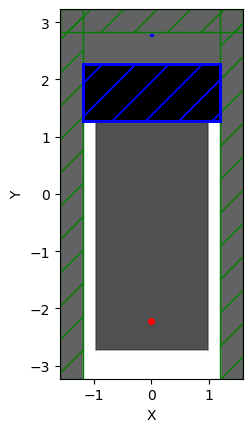

In [105]:
monitor_position, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [106]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [107]:
evaluation_history_adam = []
beta_history = []

cur_iter = [0]

numevl = 1

lr_history=[]

uf_history=[]
t_history=[]
adjgrad_history=[]
lr_history = []

optimizer = AdamOptimizer(lr=0.02, beta1=0.9)

def f(v,eta, cur_beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))
    
    f0_r, dJ_du0 = opt([v])
    
    f0=np.array([np.real(f0_r)])
    
    if v.size > 0:
        gradient0 = v*0
    
        gradient0[:] = dJ_du0

        gradient=gradient0
        
        adjgrad_norm = gradient.mean()
        adjgrad_history.append(adjgrad_norm) 

        # Optimize design
        updated_x, adam_lr, adam_uf, adam_m, adam_v, adam_t = optimizer.update(v, gradient)
        
        cur_beta= cur_beta+ npa.tanh((cur_beta-0.5)*0.01)
        evaluation_history_adam.append(f0_r)
        beta_history.append(cur_beta)
        cur_iter[0] = cur_iter[0] + 1
        lr_history.append(adam_lr)
        uf_history.append(adam_uf)
        t_history.append(adam_t)
        
        print("Current FoM0: {}".format(np.real(f0)))
        print("Current_beta:{}".format(cur_beta))
        
        return updated_x, adam_m, adam_v, cur_beta

In [33]:
total_iter = 100
cur_beta=1
n=Nx*Ny
x=np.ones(n)*0.5

for iters in range(total_iter):
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)

Current iteration: 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.48091e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0618

run 105 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.01979904]
Current_beta:1.0049999583337499
Current iteration: 2
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 107 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.02819114]
Current_beta:1.0100499149883275
Current iteration: 3
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 109 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.04883534]
Current_beta:1.0151503699086868
Current iteration: 4
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 111 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.08660993]
Current_beta:1.0203018280380722
Current iteration: 5
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 113 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.14094899]
Current_beta:1.0255047993679662
Current iteration: 6
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 115 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.20173669]
Current_beta:1.030759798988536
Current iteration: 7
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,

run 117 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.264939]
Current_beta:1.0360673471395827
Current iteration: 8
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,

run 119 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.35214706]
Current_beta:1.0414279692619992
Current iteration: 9
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 121 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.48687041]
Current_beta:1.0468421960497416
Current iteration: 10
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 123 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.66930874]
Current_beta:1.0523105635023193
Current iteration: 11
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.21865e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 125 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [0.88554548]
Current_beta:1.0578336129778085
Current iteration: 12
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 127 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [1.10436221]
Current_beta:1.0634118912463943
Current iteration: 13
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.8147e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 129 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [1.31316851]
Current_beta:1.0690459505444472
Current iteration: 14
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 131 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [1.4902299]
Current_beta:1.0747363486291392
Current iteration: 15
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4

run 133 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [1.63819993]
Current_beta:1.080483648833605
Current iteration: 16
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 135 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [1.74609837]
Current_beta:1.0862884201226513
Current iteration: 17
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 137 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [1.83630705]
Current_beta:1.092151237149025
Current iteration: 18
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 139 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [1.94552845]
Current_beta:1.0980726803102399
Current iteration: 19
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 141 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.07777032]
Current_beta:1.1040533358059712
Current iteration: 20
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 143 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.21349501]
Current_beta:1.1100937956960224
Current iteration: 21
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 145 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.33303348]
Current_beta:1.1161946579588695
Current iteration: 22
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 147 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.44457034]
Current_beta:1.1223565265507898
Current iteration: 23
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 149 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.5472849]
Current_beta:1.1285800114655797
Current iteration: 24
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 151 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.62138842]
Current_beta:1.134865728794868
Current iteration: 25
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 153 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.66309238]
Current_beta:1.1412143007890303
Current iteration: 26
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.40939e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 155 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.71527026]
Current_beta:1.1476263559187105
Current iteration: 27
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 157 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.77177217]
Current_beta:1.1541025289369569
Current iteration: 28
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 159 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.79491626]
Current_beta:1.1606434609419747
Current iteration: 29
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 161 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.82086902]
Current_beta:1.1672497994405073
Current iteration: 30
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.50611e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 163 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.868144]
Current_beta:1.1739221984118469
Current iteration: 31
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4

run 165 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.91420511]
Current_beta:1.1806613183724834
Current iteration: 32
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 167 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.94785618]
Current_beta:1.1874678264413985
Current iteration: 33
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 169 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.95256958]
Current_beta:1.194342396406009
Current iteration: 34
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 171 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.9303251]
Current_beta:1.2012857087887676
Current iteration: 35
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 173 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.93765584]
Current_beta:1.2082984509144283
Current iteration: 36
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.48227e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 175 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.97102345]
Current_beta:1.2153813169779797
Current iteration: 37
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 177 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.98579976]
Current_beta:1.2225350081132564
Current iteration: 38
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 179 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.98173446]
Current_beta:1.229760232462234
Current iteration: 39
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 181 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.97037284]
Current_beta:1.2370577052450127
Current iteration: 40
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 183 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.9637111]
Current_beta:1.2444281488304993
Current iteration: 41
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 185 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.9731346]
Current_beta:1.2518722928077923
Current iteration: 42
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 187 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.99206232]
Current_beta:1.259390874058278
Current iteration: 43
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 189 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.00090647]
Current_beta:1.2669846368284439
Current iteration: 44
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 191 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.99541172]
Current_beta:1.2746543328034172
Current iteration: 45
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 193 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.99715845]
Current_beta:1.2824007211812363
Current iteration: 46
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 195 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.00180601]
Current_beta:1.2902245687478588
Current iteration: 47
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 197 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.99580682]
Current_beta:1.2981266499529194
Current iteration: 48
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 199 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [2.99642137]
Current_beta:1.3061077469862385
Current iteration: 49
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 201 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.00929047]
Current_beta:1.3141686498550949
Current iteration: 50
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 203 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.02542497]
Current_beta:1.3223101564622644
Current iteration: 51
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.48227e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 205 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.04749835]
Current_beta:1.3305330726848372
Current iteration: 52
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 207 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.05430935]
Current_beta:1.338838212453818
Current iteration: 53
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 209 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.04783578]
Current_beta:1.3472263978345178
Current iteration: 54
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 211 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.04860851]
Current_beta:1.3556984591077454
Current iteration: 55
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 213 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.04412778]
Current_beta:1.3642552348518064
Current iteration: 56
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.60148e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 215 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.06488075]
Current_beta:1.3728975720253174
Current iteration: 57
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 217 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.05102967]
Current_beta:1.3816263260508426
Current iteration: 58
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 219 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.08534973]
Current_beta:1.3904423608993632
Current iteration: 59
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 221 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.04917405]
Current_beta:1.3993465491755857
Current iteration: 60
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.3869e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 223 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.10807812]
Current_beta:1.408339772204097
Current iteration: 61
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 225 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.11528583]
Current_beta:1.417422920116377
Current iteration: 62
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 227 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.10102723]
Current_beta:1.4265968919386753
Current iteration: 63
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 229 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.147042]
Current_beta:1.43586259568076
Current iteration: 64
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0

run 231 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.14894714]
Current_beta:1.445220948425549
Current iteration: 65
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 233 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13597211]
Current_beta:1.4546728764196306
Current iteration: 66
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 235 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.15848187]
Current_beta:1.4642193151646843
Current iteration: 67
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 6.10352e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 237 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.1520807]
Current_beta:1.473861209509807
Current iteration: 68
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4

run 239 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.1353923]
Current_beta:1.4835995137447577
Current iteration: 69
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 241 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.15626237]
Current_beta:1.4934351916941275
Current iteration: 70
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 243 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.15403436]
Current_beta:1.5033692168124422
Current iteration: 71
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 245 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.14051257]
Current_beta:1.513402572280211
Current iteration: 72
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 247 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.15262173]
Current_beta:1.5235362511009265
Current iteration: 73
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 249 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.14727712]
Current_beta:1.5337712561990275
Current iteration: 74
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 251 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13726244]
Current_beta:1.5441086005188331
Current iteration: 75
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 253 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.14480075]
Current_beta:1.5545493071244578
Current iteration: 76
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 255 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13956191]
Current_beta:1.565094409300717
Current iteration: 77
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.69685e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 257 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13874371]
Current_beta:1.5757449506550334
Current iteration: 78
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 259 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.14457434]
Current_beta:1.5865019852203524
Current iteration: 79
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 261 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13665869]
Current_beta:1.5973665775590777
Current iteration: 80
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 263 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13373483]
Current_beta:1.6083398028680373
Current iteration: 81
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 265 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13494898]
Current_beta:1.6194227470844875
Current iteration: 82
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 267 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.1320904]
Current_beta:1.6306165069931682
Current iteration: 83
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 269 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13790214]
Current_beta:1.6419221903344174
Current iteration: 84
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 271 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13991555]
Current_beta:1.6533409159133565
Current iteration: 85
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 273 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13572803]
Current_beta:1.6648738137101555
Current iteration: 86
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 275 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13694067]
Current_beta:1.6765220249913897
Current iteration: 87
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 277 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13541509]
Current_beta:1.688286702422498
Current iteration: 88
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 279 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13215897]
Current_beta:1.7001690101813534
Current iteration: 89
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 281 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.1327833]
Current_beta:1.712170124072957
Current iteration: 90
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4

run 283 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.13120074]
Current_beta:1.7242912316452652
Current iteration: 91
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 285 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.12972094]
Current_beta:1.736533532306162
Current iteration: 92
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 287 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.12988143]
Current_beta:1.7488982374415871
Current iteration: 93
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 289 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.12950463]
Current_beta:1.761386570534832
Current iteration: 94
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 291 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.1286449]
Current_beta:1.7739997672870123
Current iteration: 95
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 293 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.12654201]
Current_beta:1.7867390757387318
Current iteration: 96
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2

run 295 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.1255401]
Current_beta:1.799605756392946
Current iteration: 97
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4

run 297 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.12515682]
Current_beta:1.812601082339039
Current iteration: 98
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 299 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.12542249]
Current_beta:1.825726339378125
Current iteration: 99
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,

run 301 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
Current FoM0: [3.12639797]
Current_beta:1.8389828261495837
Current iteration: 100
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.

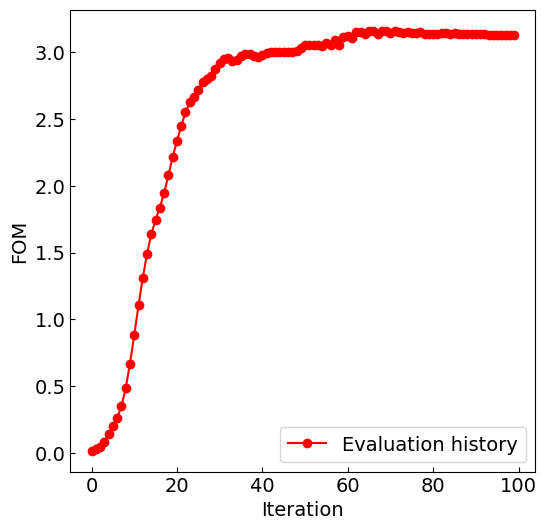

In [34]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history_adam, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("adam_weights_2lambda_pos.txt", design_variables.weights)

In [108]:
import numpy as np

data = np.loadtxt('adam_weights_1lambda_pos.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])
# data


Loaded array shape: (6171,)


In [109]:
# adam_iter100 = design_variables.weights

In [110]:
# opt.update_design([adam_iter100])

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


(-1.2, 1.2, 1.27, 2.27)

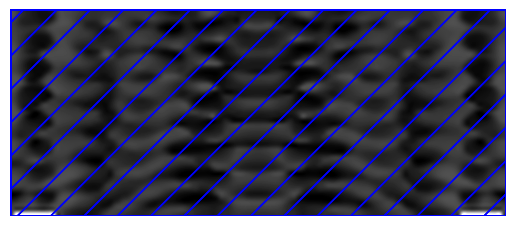

In [111]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

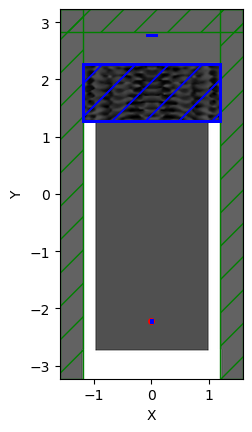

In [112]:
offset = 0.01
flux_size = 0.02
mn_size = 0.3*1/fcen

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0541751 s
time for set_conductivity = 0.00199604 s
time for set_con

<Axes: xlabel='X', ylabel='Y'>

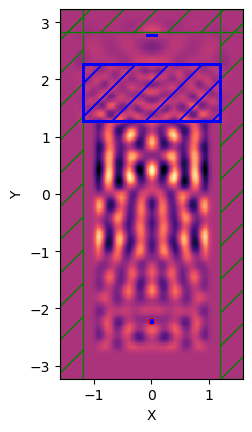

In [113]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(fields = mp.Ez, 
            #    output_plane=mp.Volume(
            #         center = monitor_position_y,
            #         size = mp.Vector3(2, 1)
            #     ),
    field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 1,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

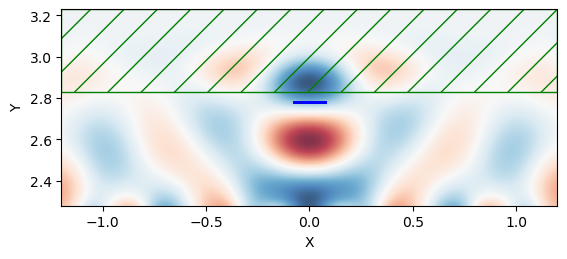

In [114]:
opt.sim.plot2D(fields = mp.Ez, 
               output_plane=mp.Volume(
                    center = monitor_position_y,
                    size = mp.Vector3(2.4, 1)
                ),
    # field_parameters={
    #     'cmap': 'magma',    # magma 컬러맵 지정
    #     'alpha': 1,       # 필드 투명도 (0.0~1.0)
    #     'interpolation': 'none'
    # }
)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


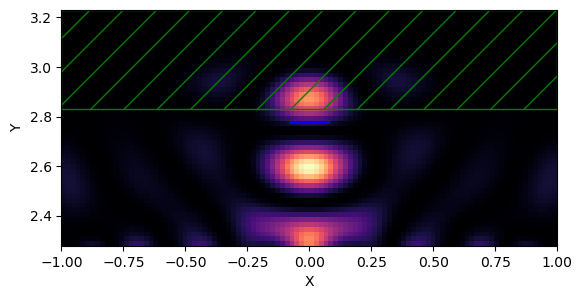

In [120]:
opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(2, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(x)**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.show()

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

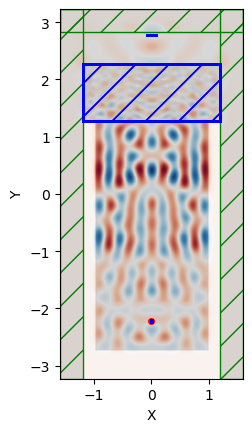

In [115]:
opt.sim.plot2D(fields = mp.Ez)

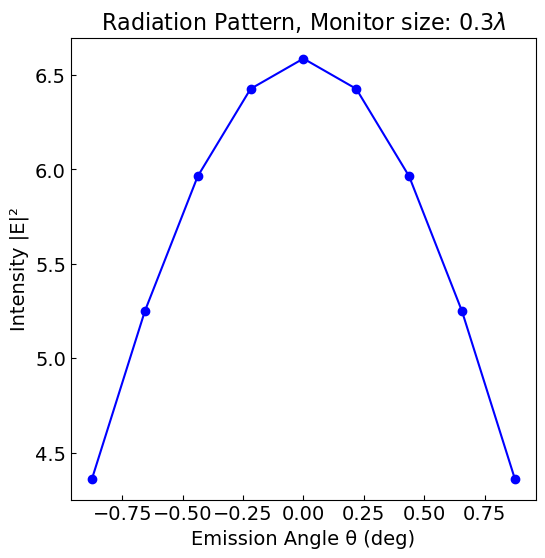

In [116]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리
theta = np.degrees(np.arctan2(x, z))               # rad → deg 변환

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(theta, I, 'bo-')
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title(r'Radiation Pattern, Monitor size: $0.3\lambda$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
freq_idx = 0

Ez_hat = sim.get_dft_array(dft_fields, mp.Ez, freq_idx)  
Hx_hat = sim.get_dft_array(dft_fields, mp.Hx, freq_idx)  

Sy_density = np.real(Ez_hat * np.conj(Hx_hat))   

L = float(monitor_size.x)      
N = Sy_density.size            
x = np.linspace(-L/2, L/2, N)  

flux_total = np.round(np.trapz(Sy_density, x)  ,5)
add_flx = np.array(mp.get_fluxes(out_flux))[0]

print(f"DFT monitor 적분으로 구한 total flux = {flux_total}")
print("Add flux로 계산한 total flux = ", add_flx)

err = np.abs((flux_total-add_flx)/add_flx)*100
print("오차율 (%) : ", err, "%")

eqe = np.round(flux_total / np.array(mp.get_fluxes(input_flux))[0] * 100,5)
print("Output flux :", flux_total)
print("Input flux :", np.round(np.array(mp.get_fluxes(input_flux))[0] ,5))
print("EQE(%) :", eqe,"%")

DFT monitor 적분으로 구한 total flux = 0.66057
Add flux로 계산한 total flux =  0.6640799517628849
오차율 (%) :  0.5285435516562905 %
Output flux : 0.66057
Input flux : 1.06613
EQE(%) : 61.95968 %
